Librerias

In [2]:
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn.tree import plot_tree

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargando el datasets

In [3]:
# Ruta del archivo Txt
df = pd.read_csv("train_new.txt", delimiter = '|') 
  
# Guardamos el dataframe en un archivo Csv
df.to_csv('hola.csv',  index = None) 

# Imprimimos los datos para comprobar
print(df.head())

  idioma                                              texto
0     en  host with After to rugby test World system, th...
1     en  and Africa in permission winners,[25] of in ye...
2     en  President tournament wearing presenting were m...
3     en  The the are 'The thirty-eight reference as Ell...
4     en  a The Rugby In and Warrant head 'The Webb and ...


Mostrar en columnas

In [4]:
df[['idioma','texto']].head()

,idioma,texto
0,en,"host with After to rugby test World system, th..."
1,en,"and Africa in permission winners,[25] of in ye..."
2,en,President tournament wearing presenting were m...
3,en,The the are 'The thirty-eight reference as Ell...
4,en,a The Rugby In and Warrant head 'The Webb and ...


Se cuentan el numero total de filas en el archivo

In [5]:
# Contar el total de filas
total_filas = df.shape[0]

print("Total de filas:", total_filas)

Total de filas: 1069


Graficamos la distribucion de los datos que tenemos en las 2 categorias (en y nl)

Podemos ver que los datos estan casi perfectamente balanceados

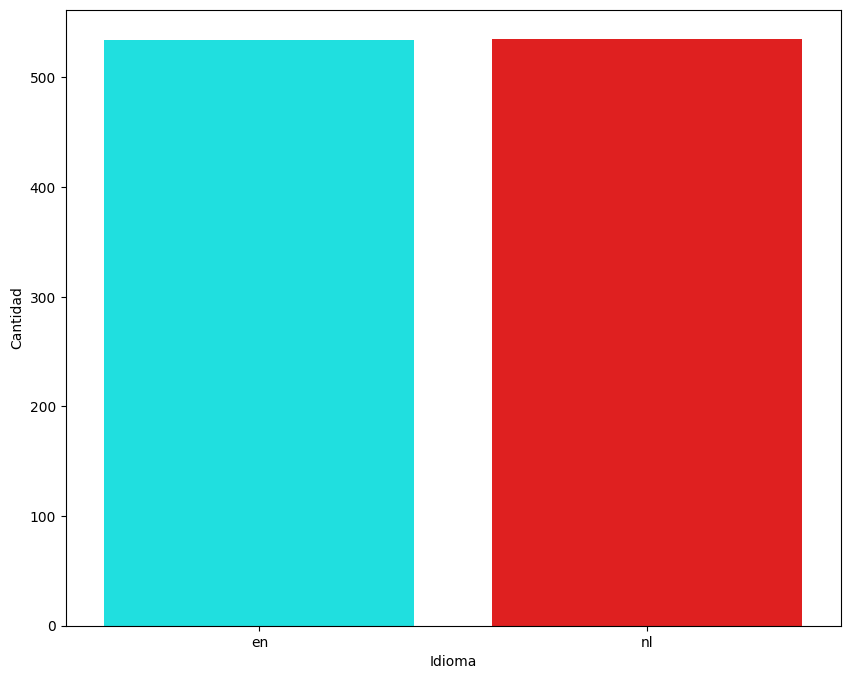

        texto
idioma       
en        534
nl        535


In [6]:
# Establecer el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear un countplot con las categorías "en" y "nl" de diferentes colores
sns.countplot(data=df, x='idioma', palette={'en': 'cyan', 'nl': 'red'})

# Configurar los ejes y etiquetas
plt.xlabel('Idioma')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

n_palabras = df.explode(column='idioma').groupby('idioma').count()
print(n_palabras)

In [59]:
def limpiar_tokenizar(texto):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()
    
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]

    
    return nuevo_texto

Asignamos estos valores a una nueva columna llamada "texto_tokenizado" y actualizamos el dataFrame

In [60]:
df['texto_tokenizado'] = df['texto'].apply(lambda x: limpiar_tokenizar(x))
df[['idioma','texto','texto_tokenizado']].to_csv('hola.csv', index=False)

Esto convierte nuestro df en uno nuevo llamado "texto_tidy" donde cada token se coloca en una fila y la columna se llama "token"

In [61]:
texto_tidy =df.explode(column='texto_tokenizado')
texto_tidy= texto_tidy.drop(columns='texto')
texto_tidy= texto_tidy.rename(columns={'texto_tokenizado':'token'})
texto_tidy.to_csv('texto_tidy.csv', index=False)

# Imprimimos los datos para comprobar
print(texto_tidy.head(10))

# Imprimimos la cantidad de filas del nuevo df "texto_tidy"
print("\nTotal de filas:", texto_tidy.shape[0])

  idioma      token
0     en       host
0     en       with
0     en      after
0     en         to
0     en      rugby
0     en       test
0     en      world
0     en     system
0     en        the
0     en  australia

Total de filas: 15909


Graficamos una nube de palabras donde se ven las palabras mas consonantes

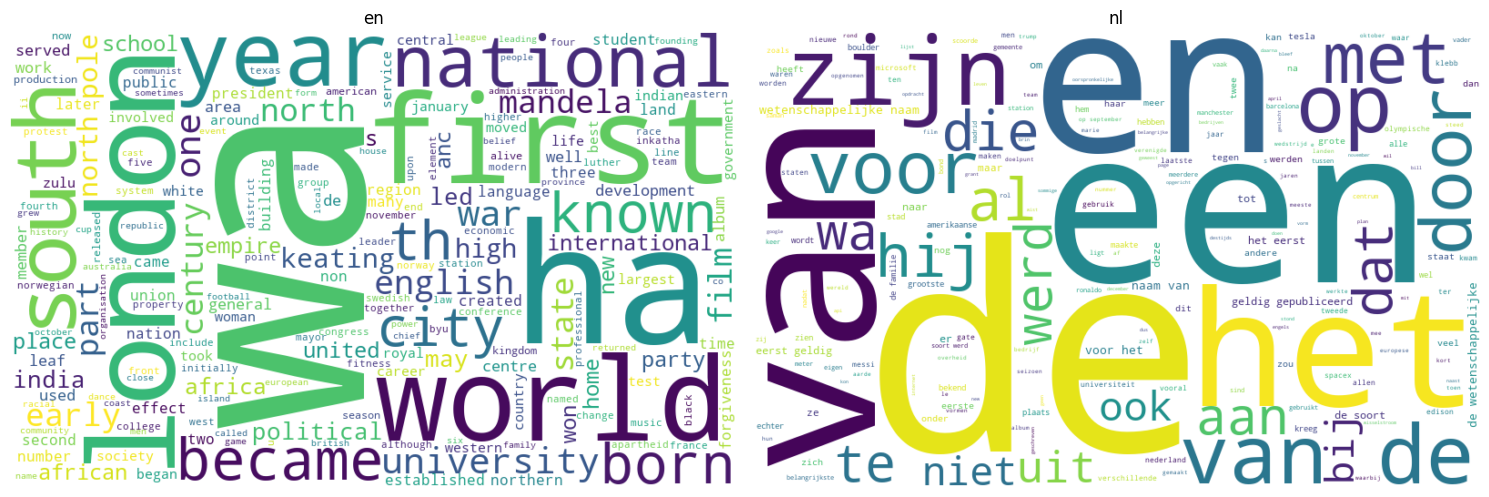

In [62]:
# Convert float items to strings in the palabras list
palabras_por_categoria = texto_tidy.groupby('idioma')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordclouds = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(' '.join(palabras))
    wordclouds[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(15, 10))
for i, (categoria, wordcloud) in enumerate(wordclouds.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

Graficamos la cantidad de palabras y su distribución 

Como podemos ver siguen una distribucion parecida a la anterior y tambien estan casi perfectamente balanceados

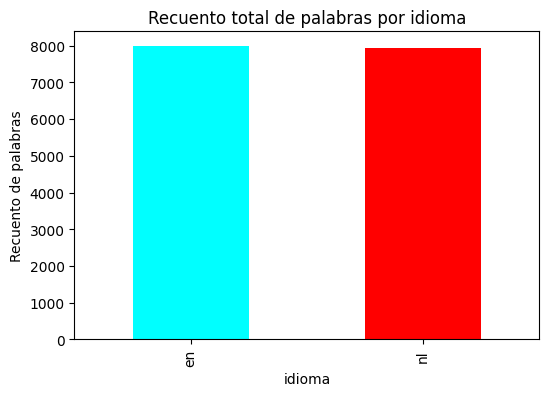


Palabras totales por idioma 

idioma
en    7986
nl    7923
Name: token, dtype: int64


In [63]:
# Recuento total de palabras por categoría
word_count = texto_tidy.groupby('idioma')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['cyan', 'red']  # Colores para las categorías 'rotten' y 'fresh'
word_count.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('idioma')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por idioma')

# Mostrar la tabla gráfica
plt.show()


print('\nPalabras totales por idioma \n')

texto_tidy.groupby(by='idioma')['token'].count()
print(word_count)

La cantidad de palabras distintas en cada idioma

In [64]:
# Palabras distintas utilizadas 
print('----------------------------')
print('Palabras distintas por idioma')
print('----------------------------')
print(texto_tidy.groupby(by='idioma')['token'].nunique())

----------------------------
Palabras distintas por idioma
----------------------------
idioma
en    2712
nl    2755
Name: token, dtype: int64


Representamos esto es un grafico circular

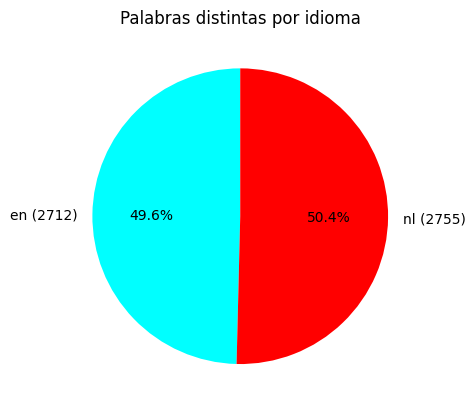

In [65]:
# Gráfico porcentaje de palabras distintas por idioma
unique_words = texto_tidy.groupby('idioma')['token'].nunique()

# Definir los colores de las categorías
colors = ['cyan', 'red']

# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por idioma')

# Mostrar el gráfico de pastel
plt.show()


Número de palabras comunes entre los idiomas

In [66]:
palabras_en = set(texto_tidy[texto_tidy.idioma == 'en']['token'])
palabras_nl = set(texto_tidy[texto_tidy.idioma == 'nl']['token'])


print(f"Palabras comunes entre Ingles y Nerlandes: {len(palabras_en.intersection(palabras_nl))}")

Palabras comunes entre Ingles y Nerlandes: 178


Creamos un nuevo df con las palabras comunes y lo llamaremos palabras_comunes

In [67]:
palabras_comunes = palabras_en.intersection(palabras_nl)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)

Graficamos una nube de palabras con las palabras comunes entre los 2 idiomas

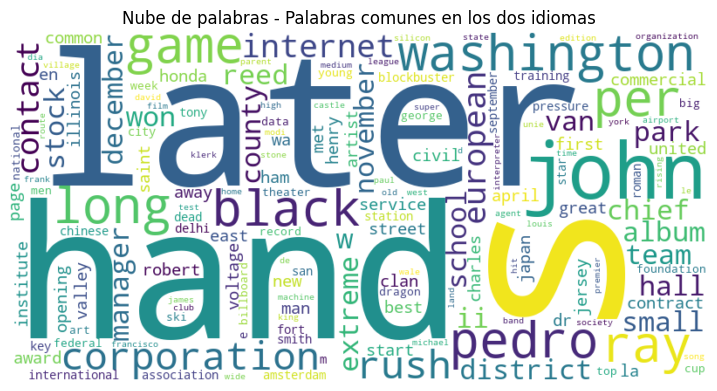

In [68]:
# Nube las palabras comunes en las dos idiomas
# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes en los dos idiomas')
plt.show()

Calculamos la probabilidad de que una palabra aparezca en un idioma, un ratio negativo negativo indica que es mas frecuente su aparicion en "nl" y uno positivo que es mas frecuente en "en"

In [69]:
# Cálculo del log of odds ratio de cada palabra (rotten vs fresh)
# ==============================================================================
# Pivotaje y despivotaje
comentarios_pivot = texto_tidy.groupby(["idioma","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="idioma", values= "count")

comentarios_pivot = comentarios_pivot.fillna(value=0)
comentarios_pivot.columns.name = None

comentarios_unpivot = comentarios_pivot.melt(value_name='n', var_name='idioma', ignore_index=False)
comentarios_unpivot = comentarios_unpivot.reset_index()

# Selección de las categorias rotten y fresh
comentarios_unpivot = comentarios_unpivot[comentarios_unpivot.idioma.isin(['en', 'nl'])]

# Se añade el total de palabras de cada categoria
comentarios_unpivot = comentarios_unpivot.merge(
                    texto_tidy.groupby('idioma')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'idioma'
                 )

# Cálculo de odds y log of odds de cada palabra
comentarios_logOdds = comentarios_unpivot.copy()
comentarios_logOdds['odds'] = (comentarios_logOdds.n + 1) / (comentarios_logOdds.N + 1)
comentarios_logOdds = comentarios_logOdds[['token', 'idioma', 'odds']] \
                    .pivot(index='token', columns='idioma', values='odds')
comentarios_logOdds.columns.name = None

comentarios_logOdds['log_odds']     = np.log(comentarios_logOdds.en/comentarios_logOdds.nl)
comentarios_logOdds['abs_log_odds'] = np.abs(comentarios_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de rotten. Esto es así porque el ratio se ha
# calculado como rotten/fresh.
comentarios_logOdds['categoria frecuente'] = np.where(comentarios_logOdds.log_odds > 0,
                                              "en",
                                              "nl"
                                    )

print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
comentarios_logOdds.sort_values('abs_log_odds', ascending=False).head(15)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,en,nl,log_odds,abs_log_odds,categoria frecuente
token,,,,,
het,0.000125,0.030414,-5.492716,5.492716,nl
een,0.000125,0.028016,-5.410596,5.410596,nl
van,0.000250,0.038869,-5.044872,5.044872,nl
to,0.017403,0.000126,4.926555,4.926555,en
voor,0.000125,0.012998,-4.642648,4.642648,nl
en,0.000250,0.025745,-4.632892,4.632892,nl
op,0.000125,0.011989,-4.561796,4.561796,nl
zijn,0.000125,0.011610,-4.529708,4.529708,nl
and,0.032929,0.000379,4.465623,4.465623,en


Graficamos los log_ods

Text(0.5, 0, 'log odds ratio (en / nl)')

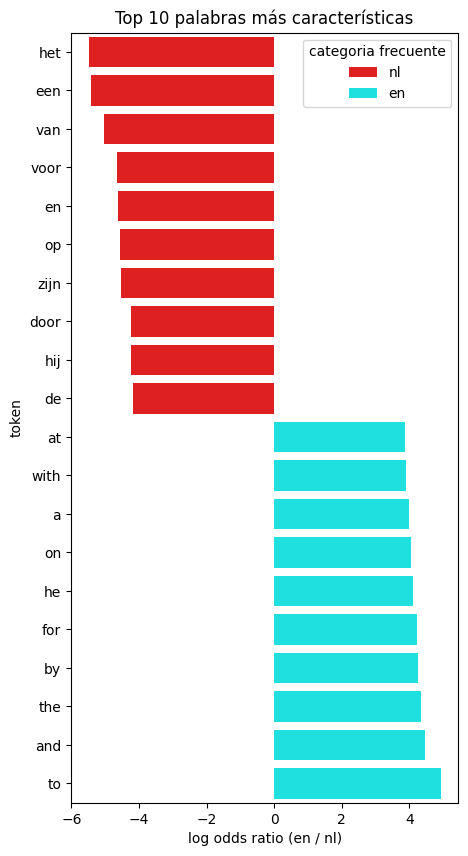

In [70]:
# Top 15 palabras más características de cada categoria


top_30 = comentarios_logOdds[['log_odds', 'abs_log_odds', 'categoria frecuente']] \
        .groupby('categoria frecuente') \
        .apply(lambda x: x.nlargest(10, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    x='log_odds',
    y='token',
    hue='categoria frecuente',
    data=top_30,
    ax=ax,
    palette={'en': 'cyan', 'nl': 'red'} 
)
ax.set_title('Top 10 palabras más características')
ax.set_xlabel('log odds ratio (en / nl)')

Frecuencia relativa de cada termino

In [71]:
# Cálculo term-frecuency (tf)

tf = texto_tidy.copy()
# Número de veces que aparece cada término en cada texto
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por texto
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
print("=======================")
tf.sort_values(by = "tf").head(10)

,token,count,total_count,tf
0,,134,134,1.0
3528,place,9,9,1.0
3527,plaatsvinden,1,1,1.0
3526,plaatsnaamtoevoeging,1,1,1.0
3525,plaatselijke,1,1,1.0
3524,plaats,10,10,1.0
3523,pizzabodems,1,1,1.0
3522,pizza's,1,1,1.0
3529,plagplekken,1,1,1.0
3521,pittsburgh,1,1,1.0
